# Low and Lou NLFFF calculation
> Define function

In [ ]:
#| default_exp lowloumag

In [ ]:
#| export
import numpy as np
import pyvista as pv
from fastcore.basics import *
from zpinn.lowlouode import find_P_and_a2

In [ ]:
#| eval:false
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True

## Parameters

### `bounds`
`bounds=[x_min, x_max, y_min, y_max, z_min, z_max]`

### `resolutions`
`resolutions=[Nx, Ny, Nz]` where `Nx`, `Ny`, `Nz` respectively mean that the number of points in x-, y-, z-axis.

### $n$ & $m$

$P_{n,m}(\mu)$ & $a^2 _{n,m}$ are eigenfunction and eigenvalues for Low-Lou ODE with fixed $n$. And $m$ is just used for denoting differenct eigenfunction and eigenvalues.

$$
\displaystyle (1-\mu^2)\frac{d^2 P_{n,m}}{d\mu^2} + n(n+1)P_{n,m} + a^2 _{n,m} \frac{1+n}{n}P_{n,m}^{1 + \frac{2}{n}} = 0
$$

### $l$ & $\Phi$

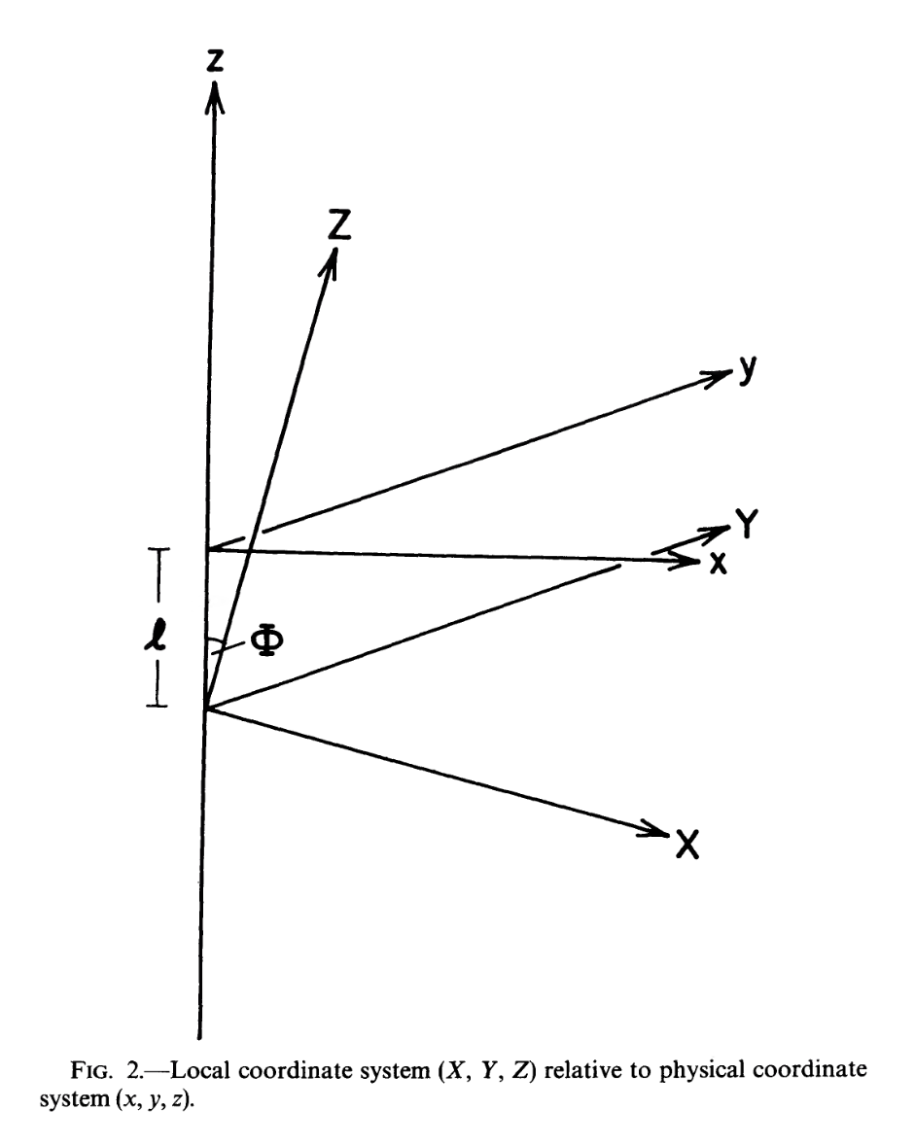

## Algorithm

For each physical coordinate $(x, y, z)$, 

1. Calculate corresponding local Cartesian coordinate $(X, Y, Z)$
2. Calculate corresponding local spherical coordinate $(r, \theta, \phi)$
3. Calculate corresponding $\mu = \cos\theta$
4. Calculate corresponding $P'_{n,m}(\mu)$ and $P_{n,m}(\mu)$ by solving Low-Lou ODE
5. Calculate corresponding $(B_r, B_\theta, B_\phi)$
6. Calculate corresponding $(B_X, B_Y, B_Z)$
7. Calculate corresponding $(B_x, B_y, B_z)$

Then, we get a vector $(B_x, B_y, B_z)$ at the point $(x, y, z)$

In [ ]:
#| export
class LowLouMag:
    "A Low and Lou (1990) NLFFF"
    def __init__(self, 
                 bounds=[-1,1,-1,1,0,2],
                 resolutions=[64,64,64],
                 n=1, m=1,
                 l=0.3, Phi=np.pi/2,
                 abs=False):
        self.bounds = bounds
        self.resolutions = resolutions
        self.n = n
        self.m = m
        self.l = l
        self.Phi = Phi
        self.abs = abs
    def __str__(self): 
        return (
            "### Low and Lou (1990) NLFFF\n"
            f"bounds = {self.bounds}<br>\n"
            f"resolutions = {self.resolutions}<br>\n"
            f"n = {self.n}<br>\n"
            f"m = {self.m}<br>\n"
            f"l = {self.l}<br>\n"
            f"Phi = {self.Phi}<br>\n"
        )
    _repr_markdown_ = __str__

In [ ]:
b = LowLouMag()
b

### Low and Lou (1990) NLFFF
bounds = [-1, 1, -1, 1, 0, 2]<br>
resolutions = [64, 64, 64]<br>
n = 1<br>
m = 1<br>
l = 0.3<br>
Phi = 1.5707963267948966<br>


In [ ]:
#| export
@patch_to(LowLouMag)
def create_physical_coordinates(self):
    x_1D = np.linspace(self.bounds[0], self.bounds[1], self.resolutions[0])
    y_1D = np.linspace(self.bounds[2], self.bounds[3], self.resolutions[1])
    z_1D = np.linspace(self.bounds[4], self.bounds[5], self.resolutions[2])
    x_spacing = np.diff(x_1D)[0]
    y_spacing = np.diff(y_1D)[0]
    z_spacing = np.diff(z_1D)[0]
    spacing = (x_spacing, y_spacing, z_spacing)
    origin = (x_1D[0], y_1D[0], z_1D[0]) # The bottom left corner of the data set
    self.grid = pv.ImageData(dimensions=self.resolutions, spacing=spacing, origin=origin)
    return self.grid

In [ ]:
b.create_physical_coordinates()

ImageData,Information
N Cells,250047
N Points,262144
X Bounds,"-1.000e+00, 1.000e+00"
Y Bounds,"-1.000e+00, 1.000e+00"
Z Bounds,"0.000e+00, 2.000e+00"
Dimensions,"64, 64, 64"
Spacing,"3.175e-02, 3.175e-02, 3.175e-02"
N Arrays,0


In [ ]:
#| eval:false
b.grid.plot(show_edges=True)

Widget(value="<iframe src='/proxy/33067/index.html?ui=P_0x7f586826f5b0_0&reconnect=auto' style='width: 99%; he…

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_local_Cartesian_coordinates(self):
    # information of point source & Z-axis
    l = self.l
    Phi = self.Phi
    
    # physical coordinates (x, y, z)
    x = self.grid.x
    y = self.grid.y
    z = self.grid.z

    # local Cartesian coordinates (X, Y, Z)
    X = x*np.cos(Phi) - (z+l)*np.sin(Phi)
    Y = y
    Z = x*np.sin(Phi) + (z+l)*np.cos(Phi)

    self.X, self.Y, self.Z = X, Y, Z

In [ ]:
b.calculate_local_Cartesian_coordinates()

In [ ]:
b.grid.x[0], b.grid.y[0], b.grid.z[0]

(-1.0, -1.0, 0.0)

In [ ]:
b.X[0], b.Y[0], b.Z[0]

(-0.30000000000000004, -1.0, -1.0)

$$r = \sqrt{X^2 + Y^2 + Z^2}$$

$$\theta= \arccos\frac{Z}{r}$$

$$\phi = \arctan2\frac{Y}{X}$$

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_local_spherical_coordinates(self):
    # local Cartesian coordinates (X, Y, Z)
    X = self.X
    Y = self.Y
    Z = self.Z

    # local spherical coordinates (r, theta, phi)
    r = np.sqrt(X**2 + Y**2 + Z**2)
    theta = np.arccos(Z/r)
    phi = np.arctan2(Y, X) 

    self.r, self.theta, self.phi = r, theta, phi

In [ ]:
b.calculate_local_spherical_coordinates()

In [ ]:
b.r[0], b.theta[0], b.phi[0]

(1.445683229480096, 2.3346567297775978, -1.8622531212727638)

`S` refers to  $\mathbf{S}_{n,m}(\mu)$ and `a2` refers to $a^2 _{n,m}$

$$
\mathbf{S}_{n,m}(\mu) = \begin{bmatrix}
                     P_{n,m}(\mu) \\
                     P'_{n,m}(\mu)
                 \end{bmatrix}
$$

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_eigenfunctions(self):
    # calculate mu=cos(theta)
    mu = np.cos(self.theta)

    # eigenfunction parameter n, m
    n = self.n
    m = self.m

    # calculate eigenfunction & its derivates and eigenvalues
    # S = [P, dP]
    S, a2 = find_P_and_a2(n, m)
    P, dP = S(mu)

    self.P, self.dP, self.a2 = P, dP, a2

In [ ]:
b.calculate_eigenfunctions()

In [ ]:
b.P[0], b.dP[0], b.a2

(2.3671821639604054, 4.145376627898734, 0.4274037235392911)

$$
\mathbf{B}(r, \theta, \phi) = B_r \hat{r} + B_\theta \hat{\theta} + B_\phi \hat{\phi}
$$

where

$$
B_r = \frac{1}{r^2 \sin\theta} \frac{\partial A}{\partial \theta}
$$

$$
B_\theta = -\frac{1}{r \sin\theta} \frac{\partial A}{\partial r}
$$

$$
B_\phi = \frac{Q}{r \sin\theta}
$$

$$
A = (r^{-n})P_{n,m}(\mu)
$$

$$
\frac{\partial A}{\partial \theta} = (- r^{-n}\sin\theta) P'_{n,m}(\mu)
$$

$$
\frac{\partial A}{\partial r} = (-n r^{-n-1}) P_{n,m}(\mu) 
$$

For $n=1$,

$$
Q(A) = \sqrt{a^2 _{n,m}} A^{1 + \frac{1}{n}}
$$

$$
\alpha = \sqrt{a^2 _{n,m}} \left(1 + \frac{1}{n} \right) A^{\frac{1}{n}}
$$

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_local_spherical_magnetic_fields(self):
    # eigenfunctions and eigenvalue
    n, m = self.n, self.m
    P, dP, a2 = self.P, self.dP, self.a2

    # r, theta info
    r, theta = self.r, self.theta
    
    A = r**(-n) * P
    dA_dtheta = -r**(-n) * np.sin(theta) * dP
    dA_dr = -n*r**(-n-1) * P
    if self.abs is True:
        Q = np.sqrt(a2) * A * np.abs(A)**(1/n)
    else:
        Q = np.sqrt(a2) * A ** (1 + 1 / n)
    
    alpha = np.sqrt(a2) * (1 + 1/n) * A**(1/n)
    
    Br = (r**2 * np.sin(theta))**(-1) * dA_dtheta
    Btheta = -1 * (r*np.sin(theta))**(-1) * dA_dr
    Bphi = (r*np.sin(theta))**(-1) * Q
    
    self.Br, self.Btheta, self.Bphi, self.alpha = Br, Btheta, Bphi, alpha

In [ ]:
b.calculate_local_spherical_magnetic_fields()

In [ ]:
b.Br[0], b.Btheta[0], b.Bphi[0], b.alpha[0]

(-1.3719698429138414,
 1.0848561237071588,
 1.6788928338791695,
 2.140955710342295)

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_local_Cartesian_magnetic_fields(self):
    Br, Btheta, Bphi = self.Br, self.Btheta, self.Bphi
    r, theta, phi = self.r, self.theta, self.phi
    
    BX = Br * np.sin(theta) * np.cos(phi) + Btheta * np.cos(theta) * np.cos(phi) - Bphi * np.sin(phi)
    BY = Br * np.sin(theta) * np.sin(phi) + Btheta * np.cos(theta) * np.sin(phi) + Bphi * np.cos(phi)
    BZ = Br * np.cos(theta) - Bphi * np.sin(theta)
    
    self.BX, self.BY, self.BZ = BX, BY, BZ

In [ ]:
b.calculate_local_Cartesian_magnetic_fields()

In [ ]:
b.BX[0], b.BY[0], b.BZ[0]

(2.1084200215587945, 1.185348144758657, -0.2634365035515541)

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate_physical_magnetic_fields(self):
    BX, BY, BZ = self.BX, self.BY, self.BZ
    Phi = self.Phi

    Bx = BX * np.cos(Phi) + BZ * np.sin(Phi)
    By = BY
    Bz = - BX * np.sin(Phi) + BZ * np.cos(Phi)
    
    self.Bx, self.By, self.Bz = Bx, By, Bz

In [ ]:
b.calculate_physical_magnetic_fields()

In [ ]:
b.Bx[0], b.By[0], b.Bz[0]

(-0.263436503551554, 1.185348144758657, -2.1084200215587945)

## Algorithm (Reminder)

For each physical coordinate $(x, y, z)$, 

1. Calculate corresponding local Cartesian coordinate $(X, Y, Z)$
2. Calculate corresponding local spherical coordinate $(r, \theta, \phi)$
3. Calculate corresponding $\mu = \cos\theta$
4. Calculate corresponding $P'_{n,m}(\mu)$ and $P_{n,m}(\mu)$ by solving Low-Lou ODE
5. Calculate corresponding $(B_r, B_\theta, B_\phi)$
6. Calculate corresponding $(B_X, B_Y, B_Z)$
7. Calculate corresponding $(B_x, B_y, B_z)$

Then, we get a vector $(B_x, B_y, B_z)$ at the point $(x, y, z)$

In [ ]:
#| export
@patch_to(LowLouMag)
def add_magnetic_field_to_grid(self):
    vectors = np.empty((self.grid.n_points, 3))
    vectors[:, 0] = self.Bx
    vectors[:, 1] = self.By
    vectors[:, 2] = self.Bz
    self.grid['B'] = vectors
    self.grid.active_vectors_name = 'B'
    magnitude = np.linalg.norm(vectors, axis=-1)
    self.grid['mag'] = magnitude
    self.grid.active_scalars_name = 'mag'
    self.grid['alpha'] = self.alpha

In [ ]:
#| export
@patch_to(LowLouMag)
def create_bottom_boundary(self):
    Nx, Ny, _ =  self.grid.dimensions
    bottom_subset = (0, Nx-1, 0, Ny-1, 0, 0)
    self.bottom = self.grid.extract_subset(bottom_subset).extract_surface()
    self.b_bottom = self.bottom['B'].reshape(Nx, Ny, 3)
    self.b_bottom = np.array(self.b_bottom)

In [ ]:
#| export
@patch_to(LowLouMag)
def calculate(self):
    self.create_physical_coordinates()
    self.calculate_local_Cartesian_coordinates()
    self.calculate_local_spherical_coordinates()
    self.calculate_eigenfunctions()
    self.calculate_local_spherical_magnetic_fields()
    self.calculate_local_Cartesian_magnetic_fields()
    self.calculate_physical_magnetic_fields()
    self.add_magnetic_field_to_grid()
    self.create_bottom_boundary()
    return self.grid

In [ ]:
b.calculate()

In [ ]:
b.grid.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : mag
Active Vectors  : B
Active Texture  : None
Active Normals  : None
Contains arrays :
    B                       float64    (262144, 3)          VECTORS
    mag                     float64    (262144,)            SCALARS
    alpha                   float64    (262144,)

In [ ]:
b.grid

ImageData (0x7f57fbf471c0)
  N Cells:      250047
  N Points:     262144
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   64, 64, 64
  Spacing:      3.175e-02, 3.175e-02, 3.175e-02
  N Arrays:     3